In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.greedy=True

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import sys 
import sklearn.metrics as metrics

sns.set_style('whitegrid')

In [8]:
df = pd.read_csv('./processed_data/merged_dataset_all_vwc_sensors.csv', sep=';', index_col=0)

df.rename(columns={'b13': 'b8a'}, inplace=True)
v3 = 'VWC_Avg.3.'
v6 = 'VWC_Avg.6.'
v9 = 'VWC_Avg.9.'

df = df.drop(columns=['EC_Avg.3.','EC_Avg.6.','EC_Avg.9.','Temp5TE_C_Avg.3.','Temp5TE_C_Avg.6.'
                      ,'Temp5TE_C_Avg.9.','AirTemp_C_Avg','RelHumid'])

df['VWC_Avg'] = df[[v3, v6, v9]].mean(axis=1) #compute average

stations = np.array(df['Station'].values)
ground = np.array([])
for station in stations:
    if station.startswith('M'):
        ground = np.append(ground, 'Marl')
    elif station.startswith('Sa'):
        ground = np.append(ground, 'Sandstone')
    else:
        ground = np.append(ground, 'Slate')
df['ground'] = ground

df.rename(index=str, columns={"VWC_Avg.3.": "Sensor 1", "VWC_Avg.6.": "Sensor 2", "VWC_Avg.9.": "Sensor 3"}, inplace=True)
df.head()

,Date,Station,Sensor 1,Sensor 2,Sensor 3,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b8a,VWC_Avg,ground
0,20161124,M_C,0.353000,0.247000,0.294000,1442.000000,1086.428571,872.285714,630.714286,959.571429,1848.571429,2161.142857,1986.285714,623.000000,38.000000,1436.857143,749.285714,2433.428571,0.298000,Marl
1,20161124,M_D,NaN,0.426000,0.256000,1485.714286,1125.571429,960.857143,787.285714,1167.714286,2049.571429,2473.428571,2489.714286,670.285714,42.000000,2102.428571,1177.000000,2923.000000,0.341000,Marl
2,20161124,M_E,NaN,0.283000,0.347889,1772.000000,1431.142857,1255.285714,1055.571429,1462.857143,2610.714286,3087.571429,2981.000000,847.428571,218.142857,2287.714286,1276.285714,3435.428571,0.315444,Marl
3,20161124,M_F,0.352944,NaN,NaN,2025.000000,1569.142857,1239.142857,1101.285714,1345.857143,1849.714286,2046.857143,1900.714286,1046.000000,456.000000,1517.571429,943.000000,2234.285714,0.352944,Marl
4,20161124,M_G,0.293000,0.266444,0.347000,1527.000000,1245.285714,993.428571,757.714286,1051.857143,1830.571429,2156.285714,2098.142857,529.000000,130.000000,1513.142857,785.142857,2369.714286,0.302148,Marl


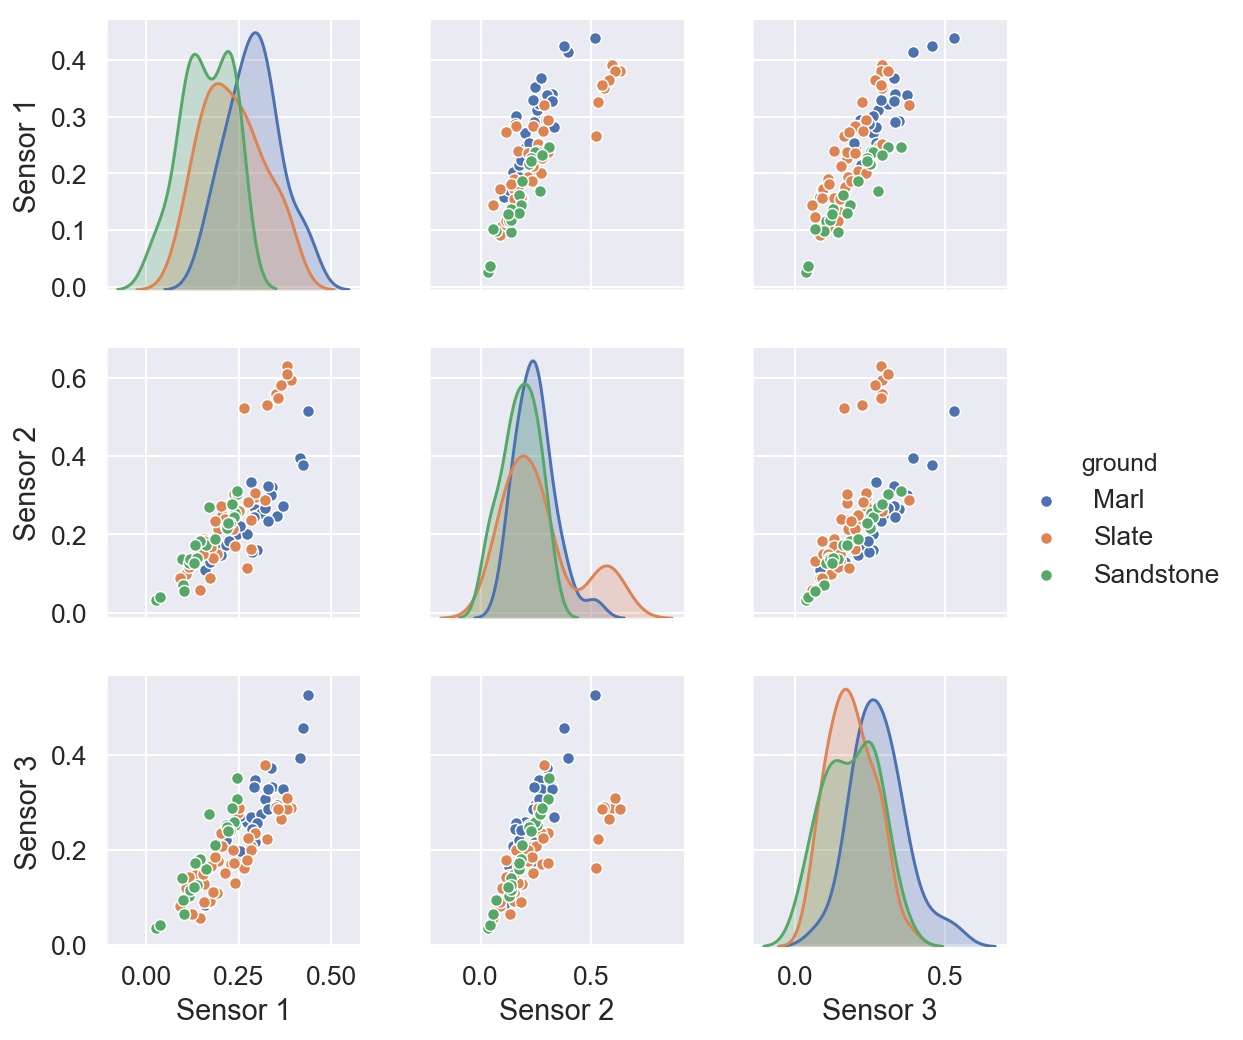

In [14]:
#sensor distributions

v3 = 'Sensor 1'
v6 = 'Sensor 2'
v9 = 'Sensor 3'
sns.set(font_scale=1.2)
sns.pairplot(df[[v3, v6, v9, 'ground']].dropna(), hue='ground')
plt.savefig('nice_plot.png', dpi=300)
plt.show()

In [4]:
#introduce class columns for every sensor and total
df['cl3'] = pd.Series(np.zeros(len(df.index)), index=df.index)
df['cl6'] = pd.Series(np.zeros(len(df.index)), index=df.index)
df['cl9'] = pd.Series(np.zeros(len(df.index)), index=df.index)
df['class'] = pd.Series(np.zeros(len(df.index)), index=df.index)

#digitize the VWC entries and write them to the new columns
bins = np.array([0.0, 0.15, 0.25, 0.35, 1.0]) # classes 1,2,3,4
inds = np.digitize(df[[v3, v6, v9]], bins, right=True)
df[['cl3', 'cl6', 'cl9']] = inds

#procedure to determin the total class value
for index, row in df.iterrows():
    values = np.array([row['cl3'], row['cl6'], row['cl9']])
    nans = np.count_nonzero(values==5)
    if nans==3: # if no sensor has an entry
        df['class'][index] = np.nan
    elif nans>0: # if 1 or 2 sensors have NaN the average is digitized
        ind = np.digitize(row['VWC_Avg'], bins, right=True)
        df['class'][index] = ind
    else: #if all sensors are working the majority wins
        unique, counts = np.unique(values, return_counts=True)
        if np.max(counts)>1:
            max_ind = np.argmax(counts)
            df['class'][index] = unique[max_ind]
        else:#if all sensors are in the same class the average is digitized
            ind = np.digitize(row['VWC_Avg'], bins, right=True)
            df['class'][index] = ind
             
df[[v3, v6, v9, 'VWC_Avg', 'cl3', 'cl6', 'cl9', 'class']].head()      

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,VWC_Avg.3.,VWC_Avg.6.,VWC_Avg.9.,VWC_Avg,cl3,cl6,cl9,class
0,0.353000,0.247000,0.294000,0.298000,4,2,3,3.0
1,NaN,0.426000,0.256000,0.341000,5,4,3,3.0
2,NaN,0.283000,0.347889,0.315444,5,3,3,3.0
3,0.352944,NaN,NaN,0.352944,4,5,5,4.0
4,0.293000,0.266444,0.347000,0.302148,3,3,3,3.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer, normalize

bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b8a']
df.dropna(subset=['class'], inplace=True)
X = df[bands]
Y = df['class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=15)

### Random Forrest

In [6]:
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, Y_train)
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

print(accuracy_score(Y_test, pred_test), accuracy_score(Y_train, pred_train))

0.5483870967741935 1.0


### Extra Trees

In [7]:
clf = ExtraTreesClassifier(n_estimators=200, random_state=0, n_jobs=-1)
clf.fit(X_train, Y_train)
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

print(accuracy_score(Y_test, pred_test), accuracy_score(Y_train, pred_train))

0.5483870967741935 1.0


### SVM

In [8]:
params_svm = {'C':np.logspace(-3, 3, 20), 'gamma':np.logspace(-10,-5,20)}
svm = SVC()
clf = GridSearchCV(svm, params_svm, n_jobs=-1) 
clf.fit(X_train, Y_train) 
print(clf.best_params_)
clf = clf.best_estimator_

clf.fit(X_train, Y_train)

pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

print(accuracy_score(Y_test, pred_test), accuracy_score(Y_train, pred_train))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 483.2930238571752, 'gamma': 2.3357214690901214e-08}
0.5483870967741935 0.5888888888888889


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### MLP (sci-kit)

In [9]:
x = normalize(df[bands])
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(df["class"])
y = pd.DataFrame(lb_results, columns=lb_style.classes_)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(100,40), alpha=1e-5, random_state=42, learning_rate_init=0.1
                    , verbose=False, n_iter_no_change=5, learning_rate='adaptive', tol=1e-10, max_iter=200)

mlp.fit(x_train, y_train)
pred_test = mlp.predict(x_test)
pred_train = mlp.predict(x_train)

print(accuracy_score(y_test, pred_test), accuracy_score(y_train, pred_train))

0.36 0.40625


### MLP (keras)

In [12]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras_metrics

random_state = 42
np.random.seed(random_state)
tf.set_random_seed(42)

model = Sequential()
model.add(Dense(104, activation='relu', input_dim=13))
model.add(Dense(52, activation='relu'))
model.add(Dense(4, activation='softmax'))

sgd = SGD(lr=0.3, decay=1e-6, momentum=0.8, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=65,
          batch_size=128, verbose=False)
score1 = model.evaluate(x_test, y_test)
score2 = model.evaluate(x_train, y_train)

print(score1[1:])
print(score2[1:])

96/96 [==============================] - 0s 77us/step
[0.4399999976158142, 0.0]
[0.4791666666666667, 0.0]
